# 이미지 인식
- 고양이 강아지 사진 구분
- CNN 이용
- 원래 데이터는 25,000개 (고양이 + 강아지)
- 여기서는 2000개로 학습을 시킨다, 검증은 1000개의 이미지 사용
- colab에서 실행 (런타임-유형변경-GPU 설정)

## 신경망 성능 개선
- 과대적합, 과소적합

##  과대적합

- 모델이 훈련 데이터에 대해서만 잘 동작하도록 만들어져서 새로운 데이터에 대해서는 오히려 잘 동작하지 못하는 경우를 과대적합(over fitting)되었다고 한다
- 머신러닝에서는 과대적합을 피해서 일반적으로 잘 동작하게 모델을 만드는 것이 매우 중요하다
- 이를 모델의 일반화(generalization)라고 한다.
- 일반화 방법
 - 모델을 단순하게 만든다
 - 더 많은 훈련 데이터 확보한다
 - 훈련 데이터에서 잡음을 줄인다 (아웃라이어 등)

- 규제화: 일반화를 위해서 모델을 단순하게 만드는 것을 모델에 제약을 가한다고 하여 규제화(regularization)라고 한다
- 과대적합 발생여부는 성능 및 손실함수의 변화를 보고 판단한다 (훈련 및 검증 데이터에 대한 결과비교)

### 신경망의 과대적합

- 신경망은 파라미터 갯수가 많아서 과대적합할 가능성이 항상 높다. 훈련 데이터 양이 많지 않을 때에는 특히 주의해야 한다.
- 과대적합이 발생하면 신경망의 구조를 단순하게 만들어야 한다.
- 그러나 신경망 구조를 너무 단순하게 만들면 표현 능력이 줄어들어 성능이 떨어지게 된다. 과소적합이 발생하는지를 살펴보아야 한다.


<img src='https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.24.12.png?raw=1' align='left' width=400>


<img  src='https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.23.54.png?raw=1' align='left' width=400>

# 데이터

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.image as mpimg
import os, os.path, shutil

- cliend URL 명령 사용

In [2]:
!curl -L \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -o ./cats_and_dogs_filtered.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 65.4M  100 65.4M    0     0   168M      0 --:--:-- --:--:-- --:--:--  168M


In [3]:
!unzip -q cats_and_dogs_filtered.zip

- 좌측의 폴더 보기에서 확인

In [4]:
base_dir = './cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# 훈련 데이터 (이미지)가 있는 폴더
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# 검증 데이터 (이미지)가 있는 폴더
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

In [5]:
train_cats_dir

'./cats_and_dogs_filtered/train/cats'

## 학습데이터 (이미지 파일) 확인

In [6]:
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])

train_dog_fnames = os.listdir(train_dogs_dir)
train_dog_fnames.sort() #  주의: sort() 결과는 리스트에  즉시 반영된다
print(train_dog_fnames[:10])

['cat.97.jpg', 'cat.251.jpg', 'cat.788.jpg', 'cat.927.jpg', 'cat.306.jpg', 'cat.675.jpg', 'cat.672.jpg', 'cat.278.jpg', 'cat.78.jpg', 'cat.572.jpg']
['dog.0.jpg', 'dog.1.jpg', 'dog.10.jpg', 'dog.100.jpg', 'dog.101.jpg', 'dog.102.jpg', 'dog.103.jpg', 'dog.104.jpg', 'dog.105.jpg', 'dog.106.jpg']


- 파일(이미지) 갯수

In [7]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500


## 이미지 샘플 보기

(245, 350, 3)


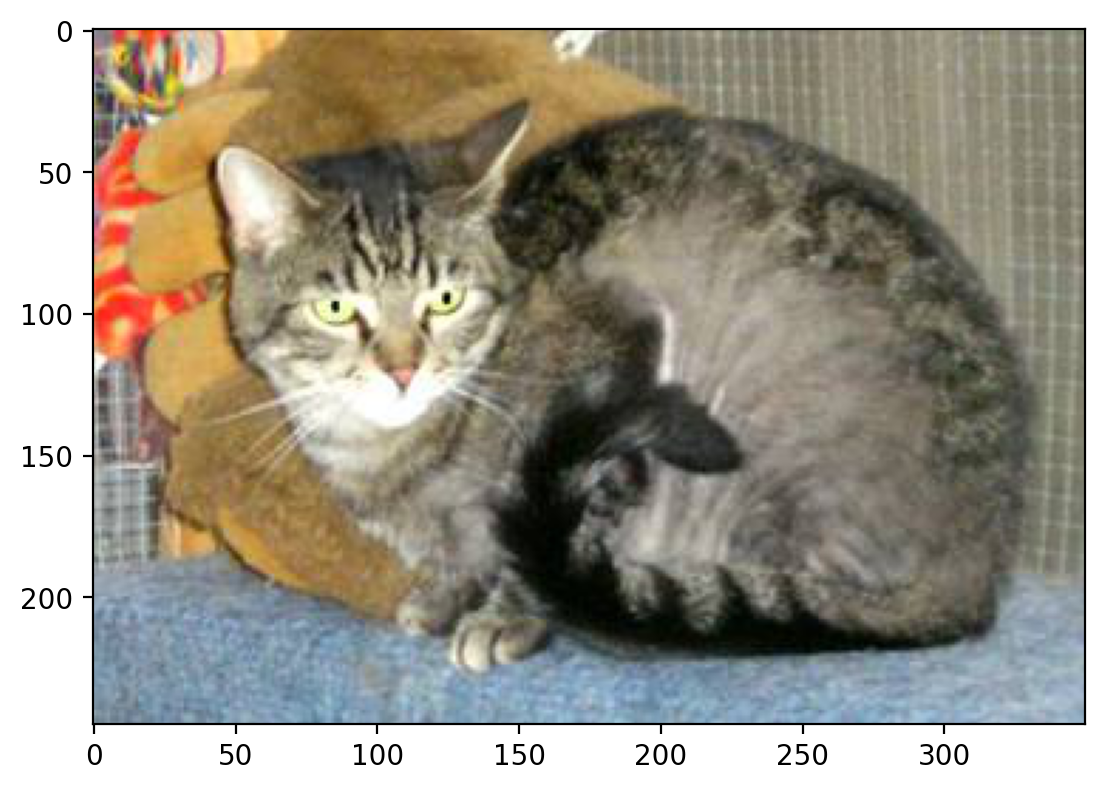

In [8]:
img_path = os.path.join(train_cats_dir, train_cat_fnames[7])
img = mpimg.imread(img_path)
print(img.shape)
plt.imshow(img)

## CNN 모델
- 이미지는 테이블에 담을 수 없으므로 폴더에서 이미지를 하나씩 불러와야 한다. ImageDataGenerator를 사용한다
- 참조 (https://stackoverflow.com/questions/53634924/keras-imagedatagenerator-equivalent-for-csv-files)


In [9]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

- 그림의 크기를 일정하게 바꾸어 사용한다
 - 150*150

## 성능 확인

In [10]:
def show_4_graphs(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

# data augmentation과 드롭아웃 사용

In [12]:
# 정사각형화
img_width = 150
img_height = 150

# 사진을 불러올때 마다 조금식 바꿔줌 (dropout)
train_datagen = ImageDataGenerator(
  rescale= 1./255, # 명암(밤/낮) 구분시 Standard Scaling 사용
  rotation_range = 60,
  width_shift_range = 0.4,
  height_shift_range = 0.2,
  shear_range=0.2,
  zoom_range=0.2,
  horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

# train_dir에서 사진을 20장씩 가져옴
train_generator = train_datagen.flow_from_directory(directory=train_dir,
											   target_size=(img_width,img_height),
 											   classes=['cats','dogs'],
											   batch_size=20)

validation_generator = validation_datagen.flow_from_directory(directory=validation_dir,
											   target_size=(img_width,img_height),
 											   classes=['cats','dogs'],
											   batch_size=20)


model = models.Sequential()

model.add(layers.Conv2D(32,(3,3), activation = 'relu',
                        input_shape=(img_width, img_height, 3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128,(3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
callbacks_list = [keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=7)]

# 학습하고 20장 가져오고...
history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=100, # 2000장을 20장씩 이므로 100이기 때문에 생략 가능
    epochs=50,
    callbacks=callbacks_list,
    validation_data=validation_generator,
    validation_steps=50)

<ipython-input-13-e40f2045ca17>:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/50
100/100 [==============================] - 36s 242ms/step - loss: 0.7316 - accuracy: 0.4950 - val_loss: 0.6940 - val_accuracy: 0.5000
Epoch 2/50
100/100 [==============================] - 27s 268ms/step - loss: 0.6956 - accuracy: 0.4865 - val_loss: 0.6926 - val_accuracy: 0.5180
Epoch 3/50
100/100 [==============================] - 20s 200ms/step - loss: 0.6947 - accuracy: 0.4930 - val_loss: 0.6919 - val_accuracy: 0.5000
Epoch 4/50
100/100 [==============================] - 19s 186ms/step - loss: 0.6934 - accuracy: 0.5015 - val_loss: 0.6890 - val_accuracy: 0.5480
Epoch 5/50
100/100 [==============================] - 20s 202ms/step - loss: 0.6918 - accuracy: 0.5155 - val_loss: 0.6867 - val_accuracy: 0.5720
Epoch 6/50
100/100 [==============================] - 18s 185ms/step - loss: 0.6929 - accuracy: 0.5300 - val_loss: 0.6783 - val_accuracy: 0.5860
Epoch 7/50
100/100 [==============================] - 20s 196ms/step - loss: 0.6854 - accuracy: 0.5625 - val_loss: 0.6511 - val_ac

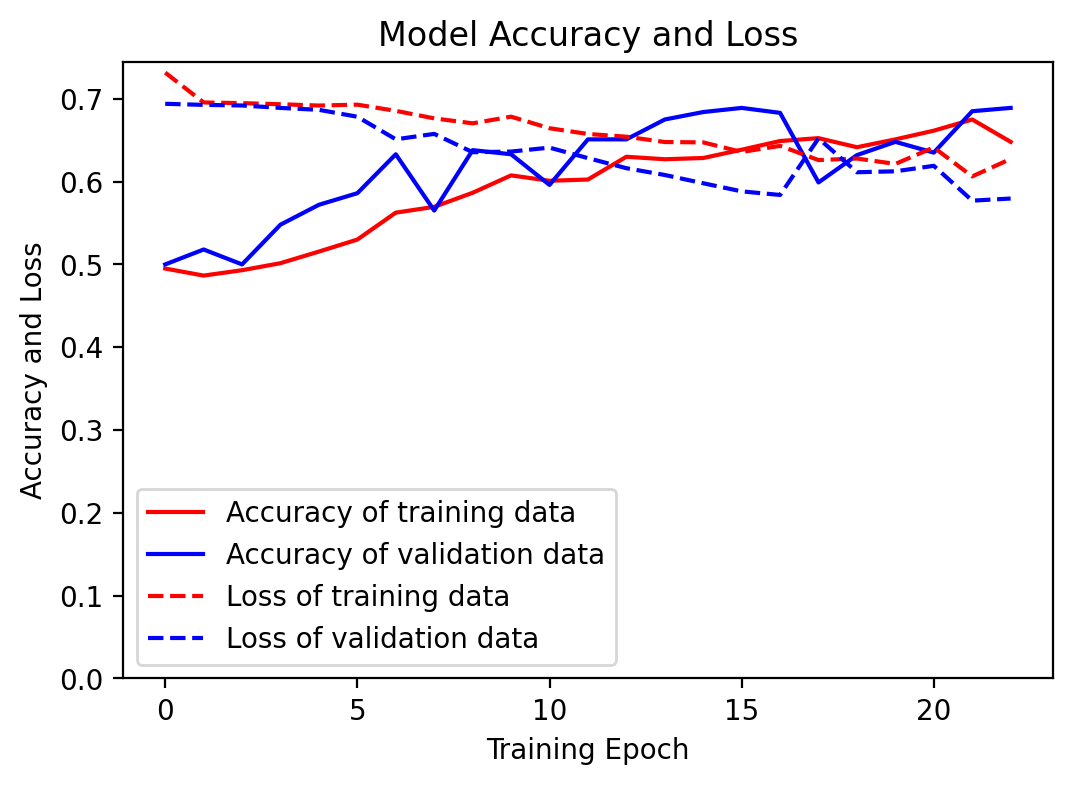

In [14]:
show_4_graphs(history)

## 테스트 이미지 파일에 대해서 모델 적용


##  강아지 사진으로  테스트

In [15]:
import cv2
folder = validation_dogs_dir

images = []
processed_images = []

for file in os.listdir(folder):
    image = mpimg.imread(os.path.join(folder, file))
    if image is not None:
        rescaled = cv2.resize(image, (150, 150))/255.0
        images.append(image)
        processed_images.append(rescaled)

processed_images = np.array(processed_images)
predictions = model.predict(processed_images)


16/16 [==============================] - 1s 9ms/step


In [21]:
# predict은 확률을 뽑아주기 때문에 강아지 판별시
(predictions[:,1].round(3)[:30] > 0.5) * 1

array([1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1])

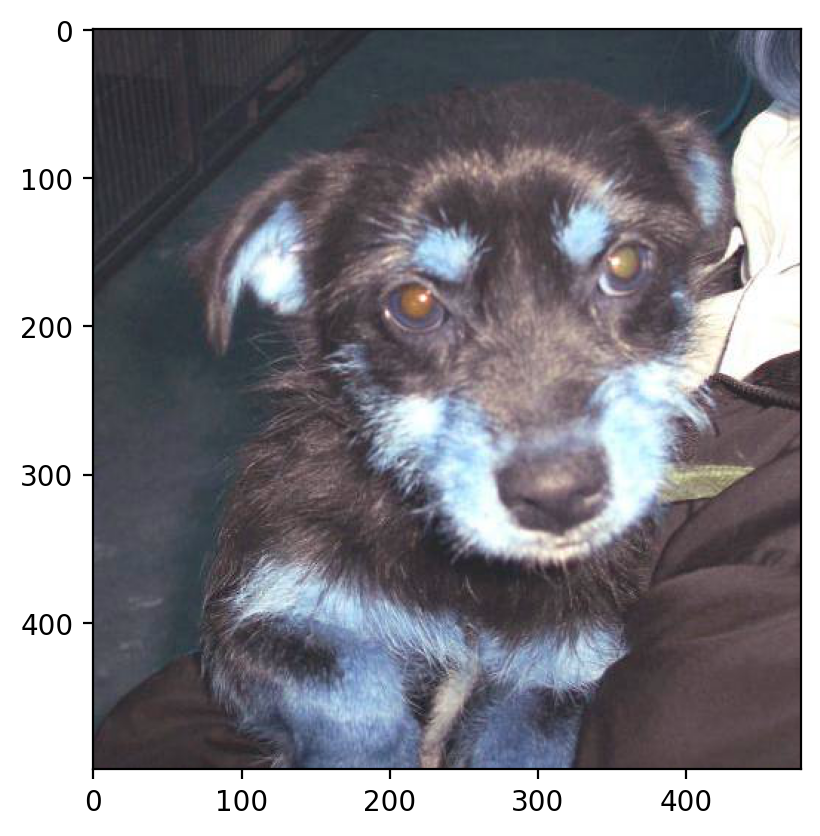

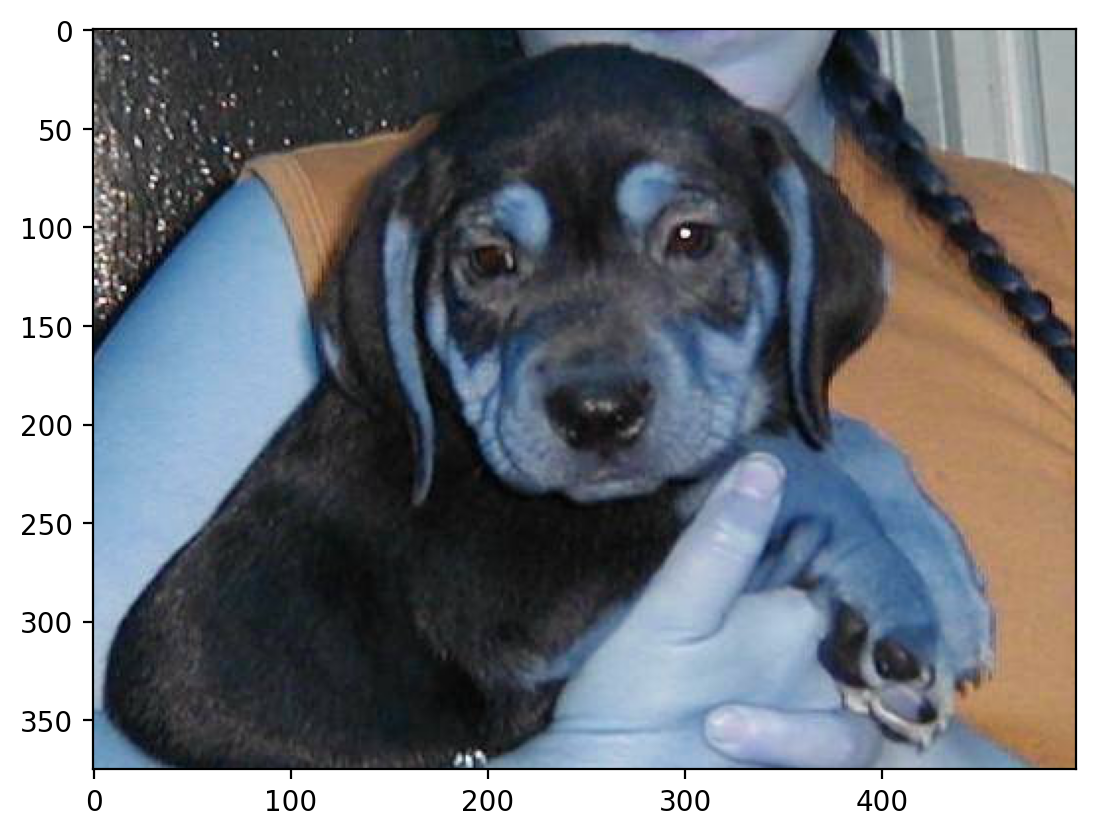

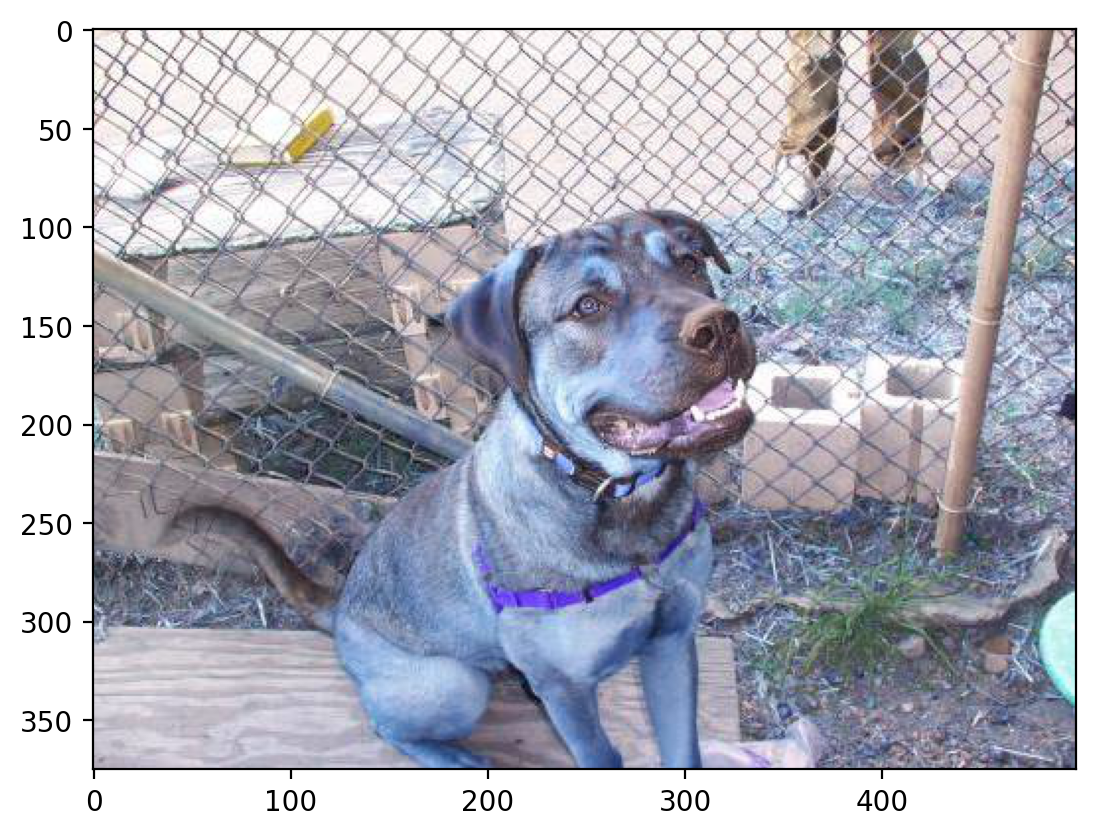

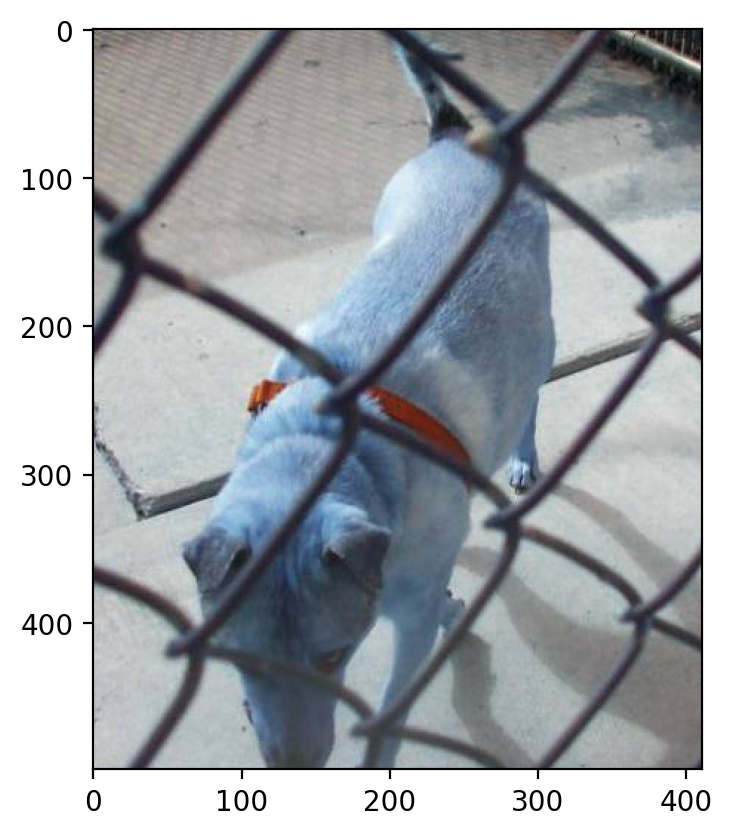

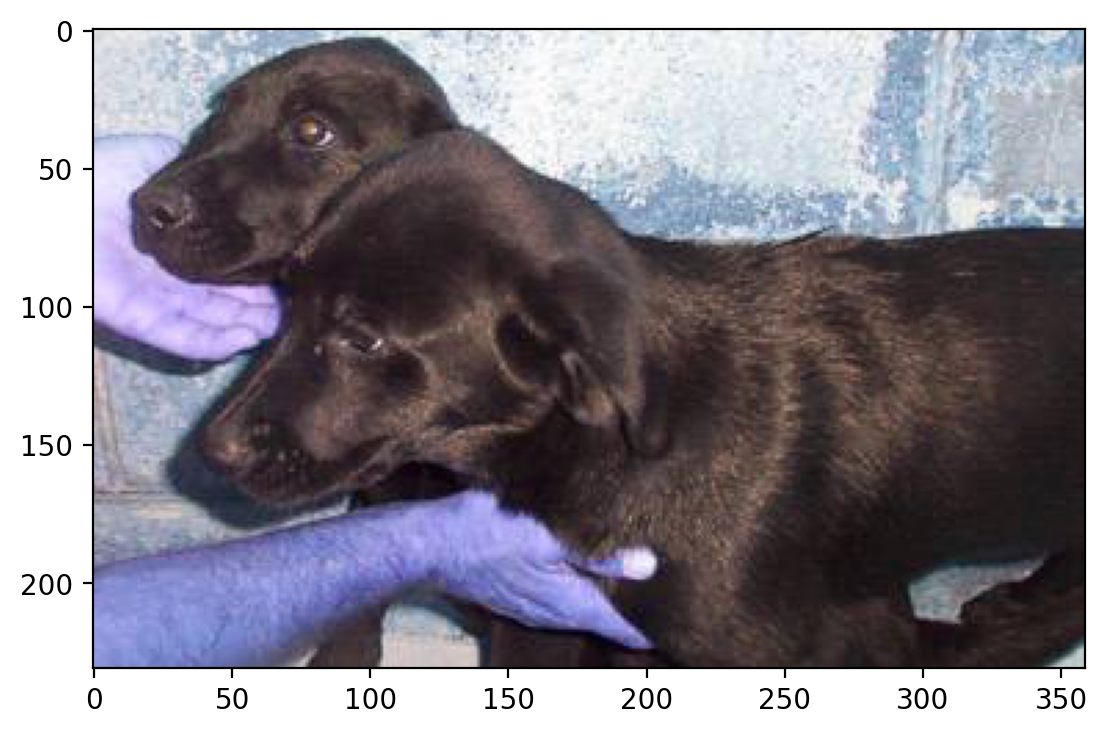

In [22]:
for index in range(5):
     plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
     plt.show()

In [23]:
predictions[:5][:,1]

array([0.6073835 , 0.46759593, 0.51162434, 0.5649346 , 0.7274347 ],
      dtype=float32)

In [24]:
(predictions[:5][:,1]  > 0.5).mean()

0.8

## 고양이 사진으로  테스트

In [25]:
folder = validation_cats_dir # 학습 종료후, 새로운 데이터를 판독하는 과정
images = []
processed_images = []

for file in os.listdir(folder):
    image = mpimg.imread(os.path.join(folder, file))
    if image is not None:
        rescaled = cv2.resize(image, (150, 150))/255.0
        images.append(image)
        processed_images.append(rescaled)

processed_images = np.array(processed_images)
predictions = model.predict(processed_images)

16/16 [==============================] - 0s 9ms/step


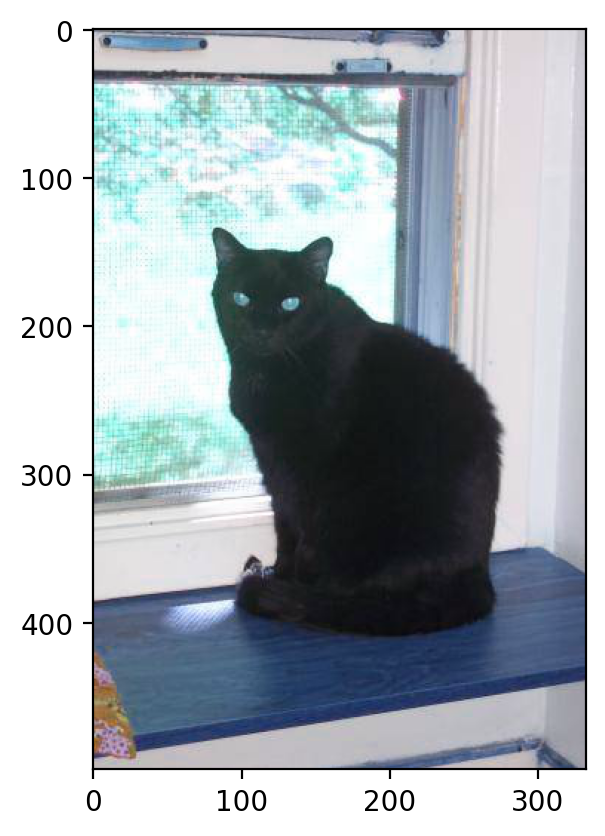

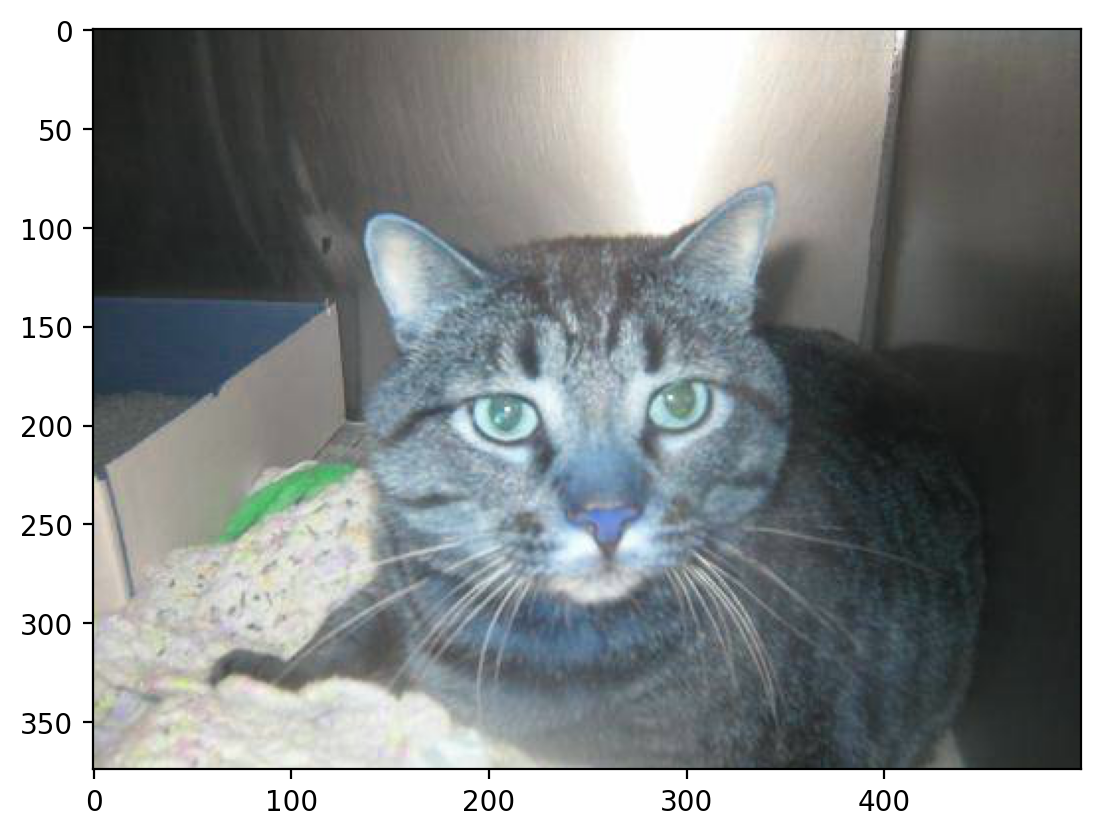

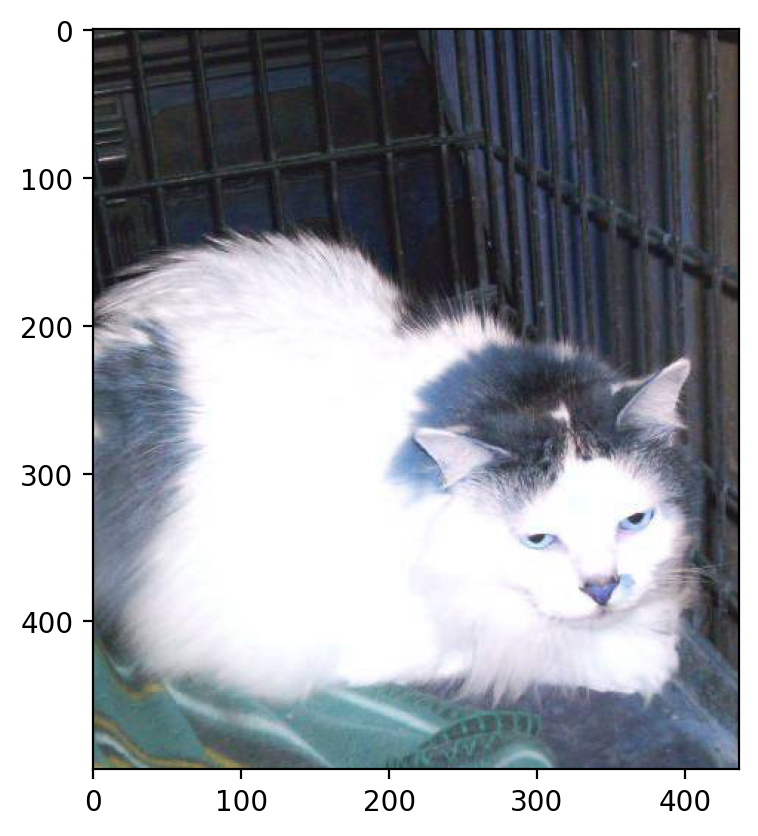

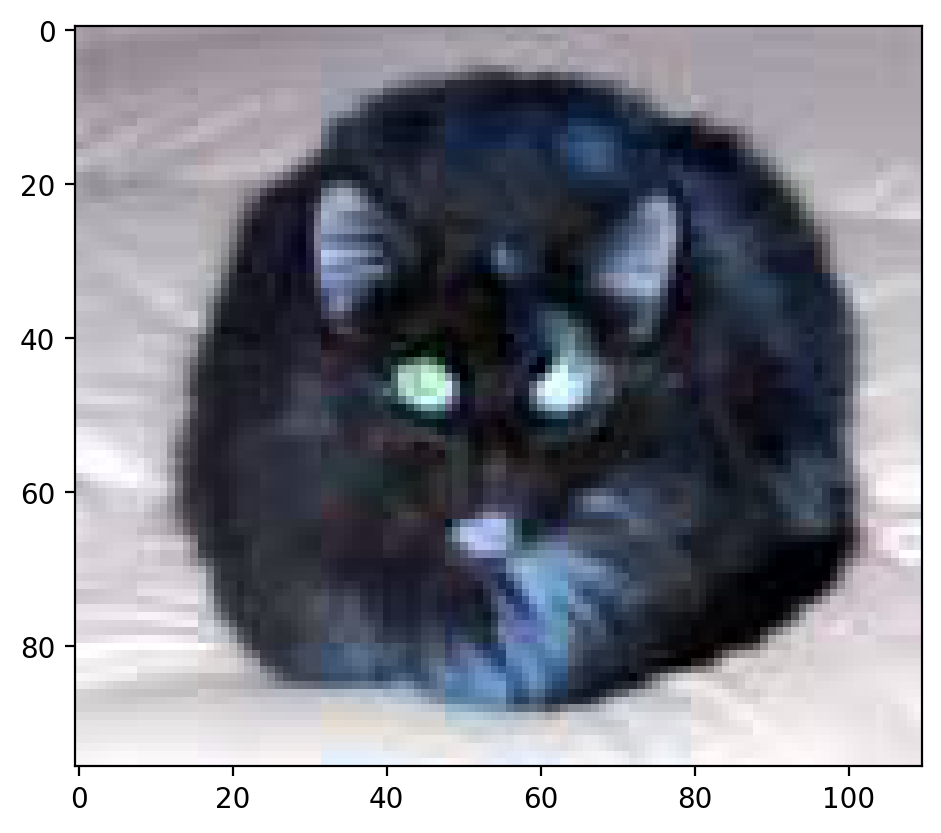

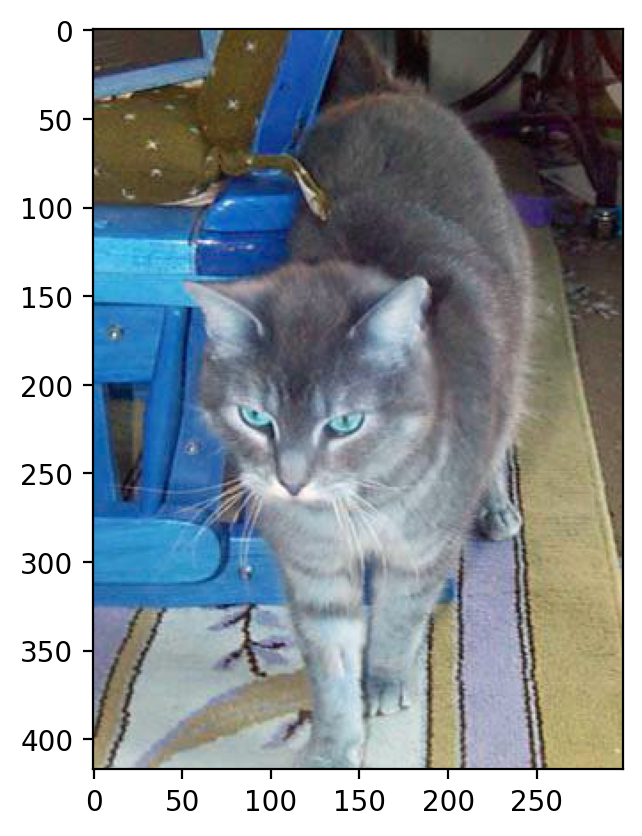

In [26]:
for index in range(5):
     plt.imshow(cv2.cvtColor(images[index], cv2.COLOR_BGR2RGB))
     plt.show()

In [27]:
(predictions[:,0] > 0.5).mean()

0.664

In [29]:
for i, v in enumerate(processed_images[:5]):
     v = v[np.newaxis, ...]
     p = model.predict(v)
     if p[:,1] > 0.5:
        print(i, "강아지")
     if p[:,1] < 0.5:
        print(i, "고양이")

1/1 [==============================] - 0s 189ms/step
0 고양이
1/1 [==============================] - 0s 18ms/step
1 고양이
1/1 [==============================] - 0s 20ms/step
2 고양이
1/1 [==============================] - 0s 19ms/step
3 고양이
1/1 [==============================] - 0s 22ms/step
4 강아지
